In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [14]:
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f_re
from masa_utils import Pelton_res_f as Pelton_res_f_np
from masa_utils import InducedPolarizationSimulation as IP_sim_np
from masa_utils import Optimization 
from masa_utils import debye_res_t
from masa_utils_pytorch import Pelton_res_f 
from masa_utils_pytorch import Pelton_con_f
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Optimization

# SIP-Jacobian for Pelton Model 

In [11]:
res0= 0.2
con8 = 10.0
eta= 0.5
tau= 0.01 #0.001
expc= 0.6
parm_true = torch.tensor([np.log(res0), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=False)
model_obs = np.r_[np.log(res0), eta, np.log(tau), expc]

In [ ]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)
freq_plot = freq
# print(freq.shape)
# print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [12]:
# simulate for Pytroch
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)

In [ ]:
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()

J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()

In [ ]:
# simulate for numpy which has analytic derivative
IP_model_np = Pelton_res_f_np(freq=freq)
sim_np = IP_sim_np(ip_model=IP_model_np)
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)

In [18]:
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]

In [16]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)

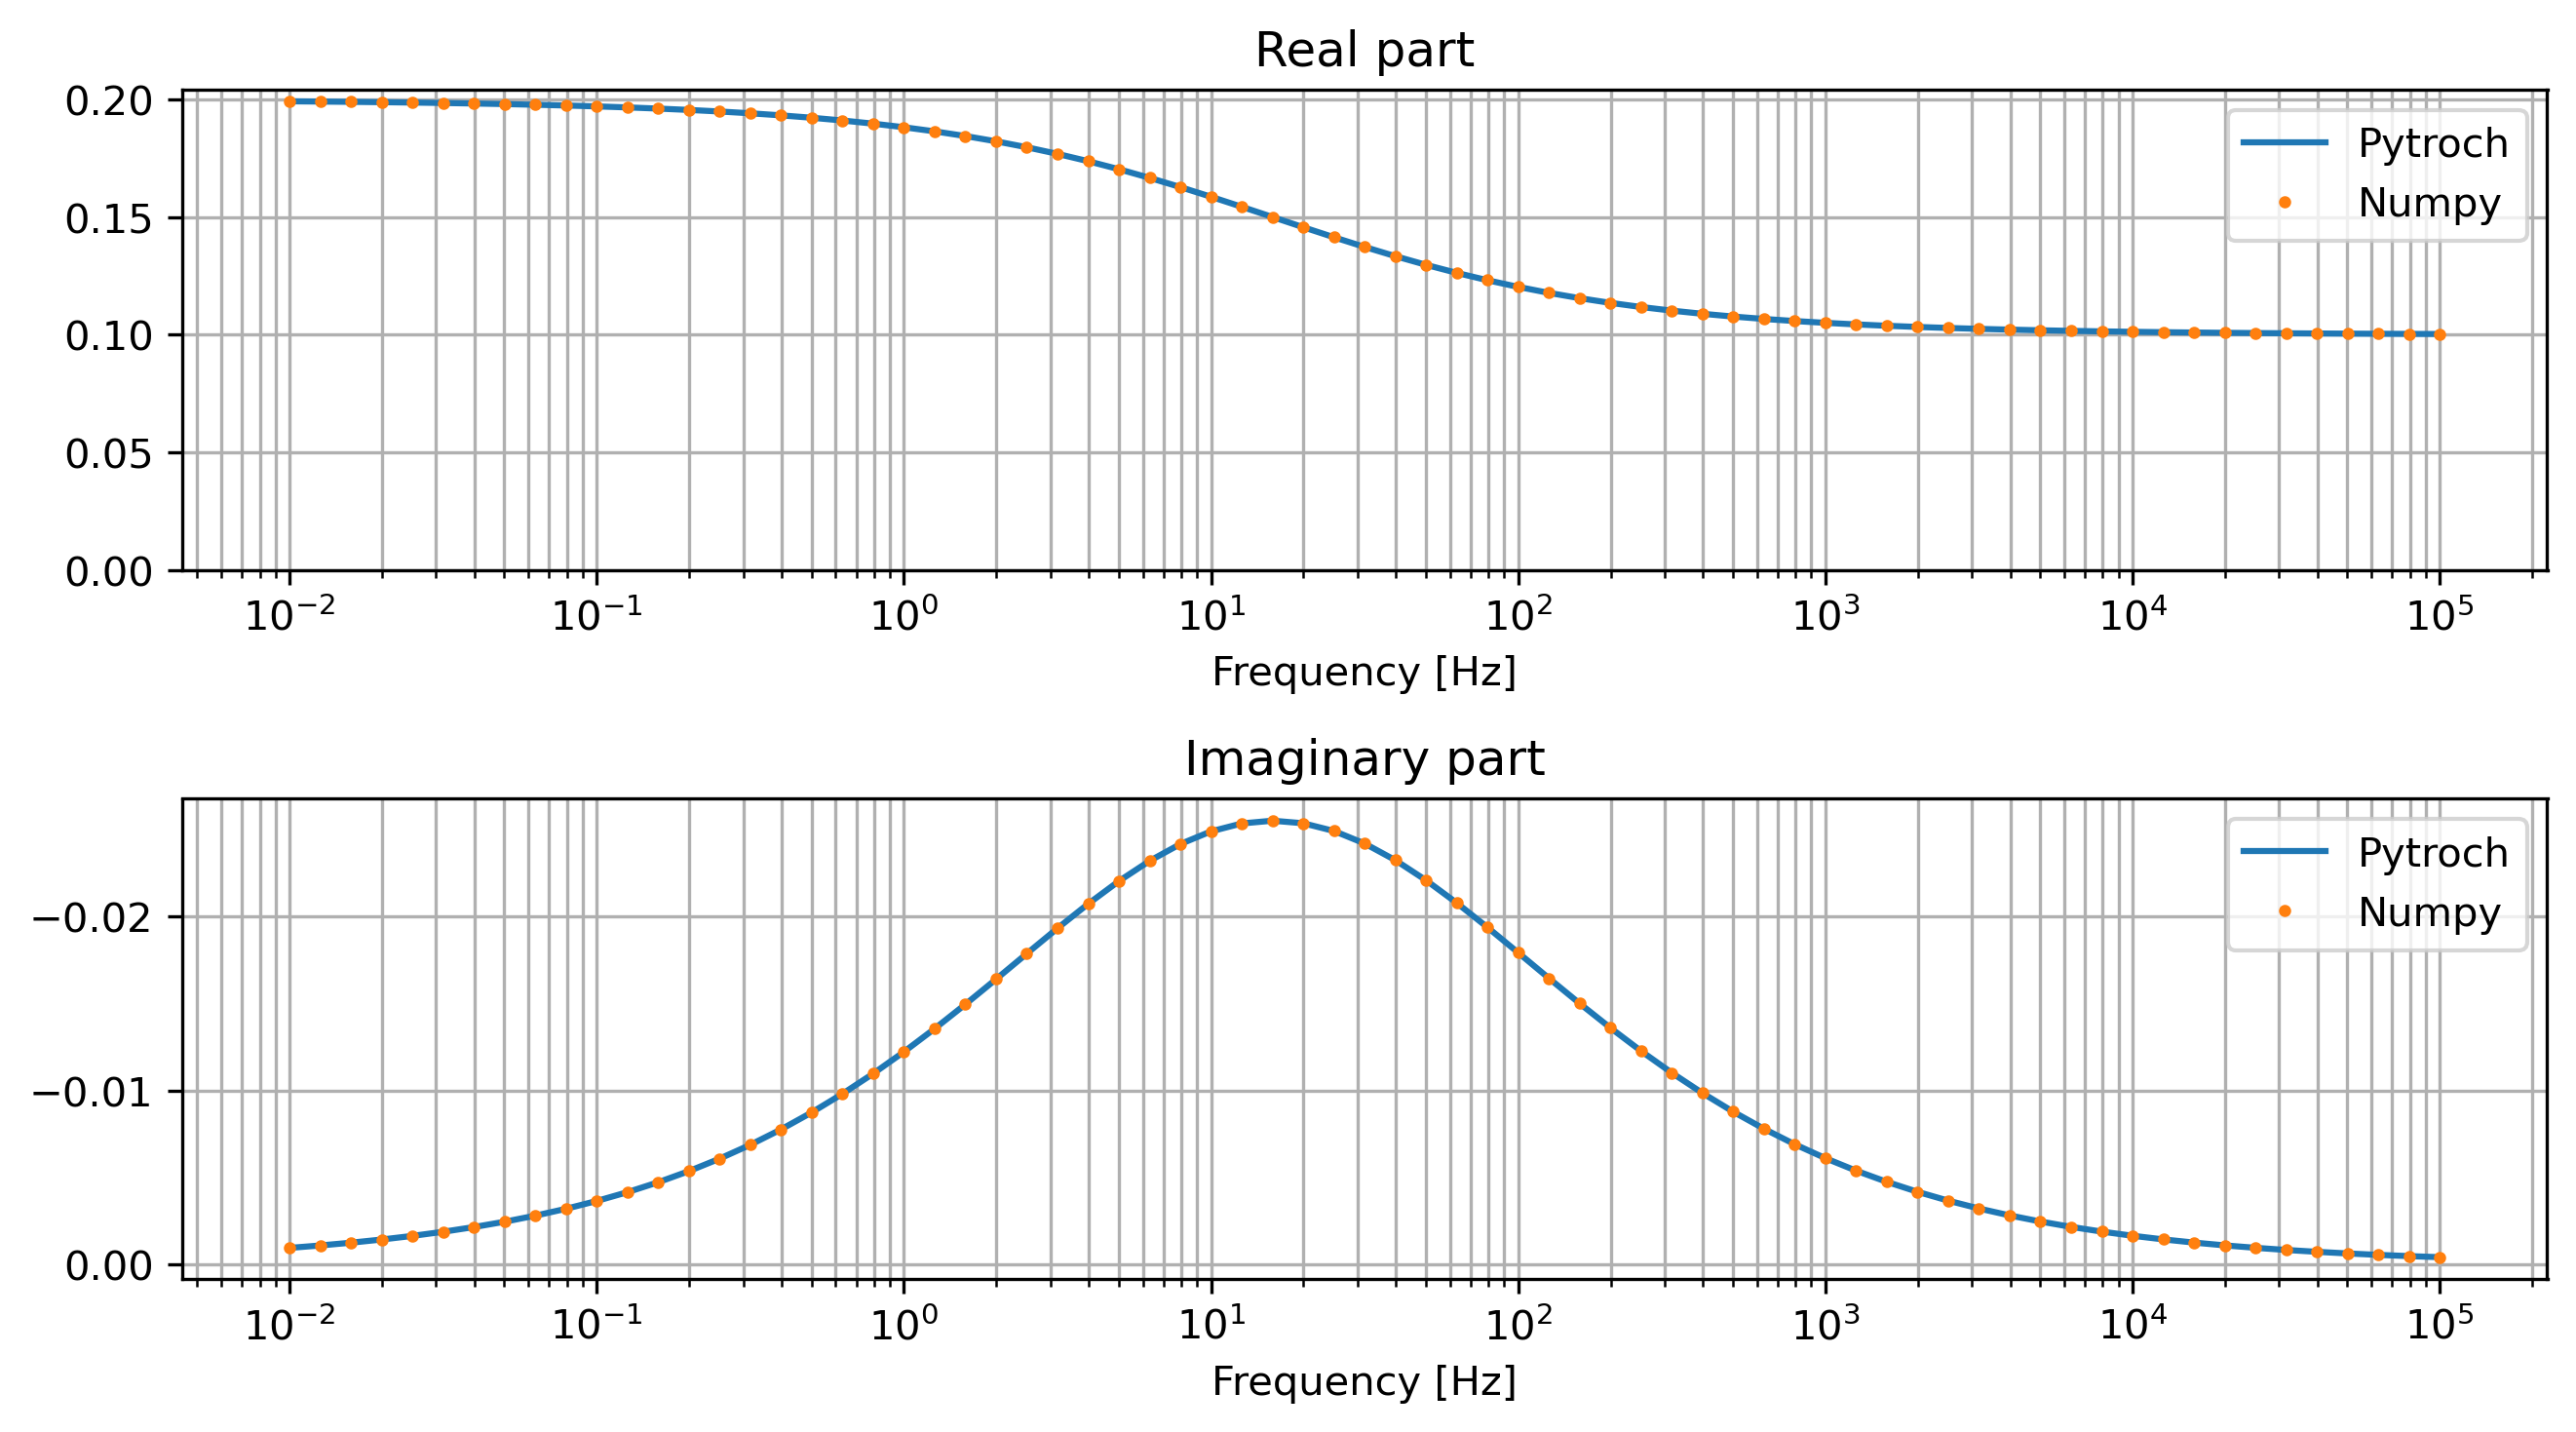

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()

# ax[2].plot(dpred_torch_real, -dpred_torch_imag, color="C0", label="Pytroch")
# ax[2].plot(dpred_np_real, -dpred_np_imag, color="C1",
#               linestyle="",markersize=4.0, marker=".",label="Numpy")
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
# ax[2].set_title("Cole-Cole plot")
# ax[2].set_xlabel("Real")
# ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("13_AuoDiffValid_Pelton_res_sip.jpg", dpi=300)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[0].semilogx(freq, J_torch_real[:,1],color = "C1", label=r"$\eta Pytroch$")
ax[0].semilogx(freq, J_np_real[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[0].semilogx(freq, J_torch_real[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[0].semilogx(freq, J_torch_real[:,3],color = "C3", label="C Pytroch")
ax[0].semilogx(freq, J_np_real[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")

ax[1].semilogx(freq, J_torch_imag[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,1],color = "C1", label=r"$\eta$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,3],color = "C3", label="C Pytorch")
ax[1].semilogx(freq, J_np_imag[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("13_AuoDiffValid_Pelton_res_sip_J.jpg", dpi=300)

In [ ]:
freqstrt_log = np.log10(1e-2)
freqend_log = np.log10(1e5)
freqstep_log = 0.2
#freqend_scalar = freqend.item()

#freq = np.logspace(freqstrt_log, freqend_log, nfreq) 
freq = 10.**np.arange(freqstrt_log, freqend_log+freqstep_log, freqstep_log)
# freq = np.r_[0., freq]
nfreq =  len(freq)
print(nfreq)
print(freq)

31
[1.00000000e-01 1.58489319e-01 2.51188643e-01 3.98107171e-01
 6.30957344e-01 1.00000000e+00 1.58489319e+00 2.51188643e+00
 3.98107171e+00 6.30957344e+00 1.00000000e+01 1.58489319e+01
 2.51188643e+01 3.98107171e+01 6.30957344e+01 1.00000000e+02
 1.58489319e+02 2.51188643e+02 3.98107171e+02 6.30957344e+02
 1.00000000e+03 1.58489319e+03 2.51188643e+03 3.98107171e+03
 6.30957344e+03 1.00000000e+04 1.58489319e+04 2.51188643e+04
 3.98107171e+04 6.30957344e+04 1.00000000e+05]


In [6]:
# nfreq= 21
# freq = np.r_[0, np.logspace(-1,3, nfreq-1)]
# print(nfreq)
# print(freq)

In [7]:
IP_model_pelton = Pelton_res_f(freq=freq)
pelton_sim = InducedPolarizationSimulation(ip_model=IP_model_pelton)

In [8]:
pelton_sim.dpred(parm_true)

array([189.93787374, 188.05347132, 185.85670215, 183.31430367,
       180.39774973, 177.08728473, 173.37664553, 169.27790345,
       164.82549281, 160.07824384, 155.11830227, 150.04633463,
       144.97334018, 140.01041472, 135.25849483, 130.80011759,
       126.69455809, 122.97668445, 119.65894323, 116.73536257,
       114.18638884, 111.98361686, 110.09383957, 108.48217851,
       107.1142939 , 105.95780196, 104.98307529, 104.16359915,
       103.47602974, 102.90006717, 102.41822402,  -6.2877227 ,
        -7.25981892,  -8.31951226,  -9.45110998, -10.62928211,
       -11.81803552, -12.97088149, -14.03276223, -14.9440984 ,
       -15.64685557, -16.09186298, -16.24597219, -16.09733742,
       -15.65738688, -14.9589202 , -14.05087739, -12.9911989 ,
       -11.83949555, -10.65095023,  -9.47223092,  -8.33952782,
        -7.27835854,  -6.30457759,  -5.42602824,  -4.6443928 ,
        -3.95694927,  -3.35807812,  -2.84046255,  -2.39598783,
        -2.01637747,  -1.69361611])

In [9]:
pelton_sim.J(parm_true)
print(pelton_sim.J(parm_true))

[[ 1.89937874e+02 -2.01242525e+01 -3.77800679e+00  5.57741991e+01]
 [ 1.88053471e+02 -2.38930574e+01 -4.41855317e+00  5.95957738e+01]
 [ 1.85856702e+02 -2.82865957e+01 -5.13404478e+00  6.26225731e+01]
 [ 1.83314304e+02 -3.33713927e+01 -5.91792260e+00  6.44596157e+01]
 [ 1.80397750e+02 -3.92045005e+01 -6.75583380e+00  6.46670545e+01]
 [ 1.77087285e+02 -4.58254305e+01 -7.62377988e+00  6.27999031e+01]
 [ 1.73376646e+02 -5.32467089e+01 -8.48710484e+00  5.84704287e+01]
 [ 1.69277903e+02 -6.14441931e+01 -9.30112342e+00  5.14294156e+01]
 [ 1.64825493e+02 -7.03490144e+01 -1.00141234e+01  4.16527923e+01]
 [ 1.60078244e+02 -7.98435123e+01 -1.05730124e+01  2.94101058e+01]
 [ 1.55118302e+02 -8.97633955e+01 -1.09310041e+01  1.52868240e+01]
 [ 1.50046335e+02 -9.99073307e+01 -1.10557179e+01  1.39484878e-01]
 [ 1.44973340e+02 -1.10053320e+02 -1.09354279e+01 -1.50173465e+01]
 [ 1.40010415e+02 -1.19979171e+02 -1.05814478e+01 -2.91676069e+01]
 [ 1.35258495e+02 -1.29483010e+02 -1.00258293e+01 -4.14506876e

# define optimization for pelton

In [10]:
relative_error = 0.01#0.05
noise_floor = 0.0
dinit = pelton_sim.dpred(parm_init)
dobs_clean = pelton_sim.dpred(parm_true)
abs_value = np.abs(dobs_clean[:nfreq] + 1.0j*dobs_clean[nfreq:])
abs_value = np.r_[abs_value, abs_value]
dobs = np.zeros_like(dobs_clean)
random_numbers = np.random.rand(len(dobs_clean))

np.random.seed(0)
dobs = ( dobs_clean
    + np.random.randn(len(dobs_clean)) * np.sqrt(
        (relative_error * abs_value)**2 
        + (noise_floor*np.ones(len(dobs_clean)))**2
        ))
dobs_error = np.sqrt((relative_error * abs_value)**2 + noise_floor*np.ones(len(dobs_clean))**2)

In [11]:
print(dobs_error)
dobs = dobs_error*np.random.randn(len(dobs_clean)) + dobs_clean 

[1.9004192  1.88193552 1.86042812 1.83557777 1.80710624 1.77481189
 1.73861166 1.6985855  1.65501568 1.60841127 1.55950748 1.50923272
 1.45864299 1.40883179 1.36083172 1.31552643 1.27358872 1.2354529
 1.20132033 1.17119034 1.1449052  1.12219896 1.10274209 1.08617792
 1.07214935 1.06031662 1.05036769 1.04202321 1.03503766 1.02919821
 1.02432226 1.9004192  1.88193552 1.86042812 1.83557777 1.80710624
 1.77481189 1.73861166 1.6985855  1.65501568 1.60841127 1.55950748
 1.50923272 1.45864299 1.40883179 1.36083172 1.31552643 1.27358872
 1.2354529  1.20132033 1.17119034 1.1449052  1.12219896 1.10274209
 1.08617792 1.07214935 1.06031662 1.05036769 1.04202321 1.03503766
 1.02919821 1.02432226]


In [12]:
opt_pelton = Optimization(sim=pelton_sim, dobs=dobs)

In [13]:
#Wd = opt_pelton.get_Wd(ratio=relative_error, plateau=noise_floor)
opt_pelton.Wd  = np.diag(1/dobs_error)
Ws = opt_pelton.get_Ws(mvec=parm_init)

In [14]:
beta0 = opt_pelton.BetaEstimate_byEig(mvec=parm_init, update_Wsen=True)
print(beta0)

241606.26877920606


In [15]:
pelton_sim.project_convex_set(parm_init)

array([ 4.60517019,  0.1       , -6.90775528,  0.6       ])

In [16]:
niter = 50
mpred,error_prg, mvec_prg = opt_pelton.GaussNewton(
    mvec_init=parm_init,niter=niter,beta0=beta0, update_Wsen=True)


  1, beta:2.4e+05, step:1.0e+00, gradient:6.2e+04,  f:8.5e+03
  2, beta:2.4e+05, step:1.0e+00, gradient:3.4e+03,  f:8.1e+03
  3, beta:1.2e+05, step:1.0e+00, gradient:1.8e+04,  f:6.5e+03
  4, beta:1.2e+05, step:1.0e+00, gradient:7.1e+03,  f:5.8e+03
  5, beta:6.0e+04, step:1.0e+00, gradient:1.5e+04,  f:4.2e+03
  6, beta:6.0e+04, step:1.0e+00, gradient:7.9e+03,  f:3.4e+03
  7, beta:3.0e+04, step:1.0e+00, gradient:1.1e+04,  f:1.9e+03
  8, beta:3.0e+04, step:1.0e+00, gradient:2.8e+03,  f:1.8e+03
  9, beta:1.5e+04, step:1.0e+00, gradient:6.3e+03,  f:9.6e+02
 10, beta:1.5e+04, step:1.2e-01, gradient:2.4e+03,  f:9.5e+02
 11, beta:7.6e+03, step:1.0e+00, gradient:5.4e+03,  f:3.9e+02
 12, beta:7.6e+03, step:1.0e+00, gradient:1.9e+03,  f:3.3e+02
 13, beta:3.8e+03, step:1.0e+00, gradient:2.2e+03,  f:1.4e+02
 14, beta:3.8e+03, step:3.9e-03, gradient:8.7e+02,  f:1.4e+02
 15, beta:1.9e+03, step:1.0e+00, gradient:1.8e+03,  f:6.7e+01
 16, beta:1.9e+03, step:1.6e-02, gradient:3.8e+02,  f:6.7e+01
 17, bet

In [17]:
mpred_pelton = mpred
dest_pelton =  pelton_sim.dpred(mpred)

# debye sum model

In [18]:
taustrt_log = np.log10(1e-5)
tausend_log = np.log10(1e1)
taustep_log = 0.2
#freqend_scalar = freqend.item()

taus = 10.**np.arange(freqstrt_log, freqend_log+freqstep_log, freqstep_log)
#taus = np.r_[0., freq]

taus = 10.**np.r_[np.arange(-5,2+0.2,0.2),3.0]
ntaus = len(taus)
print(ntaus)
#taus = np.r_[10.**np.arange(-4,1+0.2,0.2)]
#taus = np.r_[0,taus]
#taus = np.r_[10.**np.arange(-5,2+0.5,0.5)]
print(taus)
IP_model_debye = Debye_sum_res_f(freq=freq, taus=taus, proj_tol=1e-7, proj_maxiter=1000)
# IP_model_debye = Debye_sum2_res_f(freq=freq, taus=taus, proj_tol=1e-7, proj_maxiter=1000)

37
[1.00000000e-05 1.58489319e-05 2.51188643e-05 3.98107171e-05
 6.30957344e-05 1.00000000e-04 1.58489319e-04 2.51188643e-04
 3.98107171e-04 6.30957344e-04 1.00000000e-03 1.58489319e-03
 2.51188643e-03 3.98107171e-03 6.30957344e-03 1.00000000e-02
 1.58489319e-02 2.51188643e-02 3.98107171e-02 6.30957344e-02
 1.00000000e-01 1.58489319e-01 2.51188643e-01 3.98107171e-01
 6.30957344e-01 1.00000000e+00 1.58489319e+00 2.51188643e+00
 3.98107171e+00 6.30957344e+00 1.00000000e+01 1.58489319e+01
 2.51188643e+01 3.98107171e+01 6.30957344e+01 1.00000000e+02
 1.00000000e+03]


In [19]:
#taus_a =  np.ones(len(taus))/len(taus)
taus_a = np.zeros(len(taus))
#taus_a[5] = 0.3
parm_init_debye =np.r_[parm_init[:2], taus_a]
print(parm_init_debye)

[4.60517019 0.1        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [20]:
debye_sim = InducedPolarizationSimulation(ip_model=IP_model_debye)

In [21]:
debye_sim.dpred(parm_init_debye)

array([90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.,
       90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.,
       90., 90., 90., 90., 90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [22]:
debye_sim.J(parm_init_debye)

array([[ 9.00000000e+01, -1.00000000e+02,  1.00000000e+01, ...,
         6.35863686e-03,  2.53238813e-03,  2.53302317e-05],
       [ 9.00000000e+01, -1.00000000e+02,  1.00000000e+01, ...,
         2.53238813e-03,  1.00831556e-03,  1.00841623e-05],
       [ 9.00000000e+01, -1.00000000e+02,  1.00000000e+01, ...,
         1.00831556e-03,  4.01442019e-04,  4.01457974e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -3.44689679e+00, ...,
        -6.33607241e-07, -3.99779142e-07, -3.99779142e-08],
       [ 0.00000000e+00,  0.00000000e+00, -2.37154216e+00, ...,
        -3.99779142e-07, -2.52243586e-07, -2.52243586e-08],
       [ 0.00000000e+00,  0.00000000e+00, -1.55223096e+00, ...,
        -2.52243586e-07, -1.59154943e-07, -1.59154943e-08]])

In [23]:
opt_debye = Optimization(sim=debye_sim, dobs=dobs)

In [24]:
#Wd = opt_pelton.get_Wd(ratio=relative_error, plateau=noise_floor)
opt_debye.Wd  = np.diag(1/dobs_error)
Ws = opt_debye.get_Ws(mvec=parm_init_debye)

In [25]:
Wx = opt_debye.get_Wx_Debye_sum(mvec=parm_init_debye)
opt_debye.alphax = 1e3
opt_debye.alphas =  1e-3
print(Wx)

[[ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  0. -0. ...  0.  0.  0.]
 ...
 [ 0.  0. -0. ...  1.  0.  0.]
 [ 0.  0. -0. ... -1.  1.  0.]
 [ 0.  0. -0. ...  0. -1.  1.]]


In [26]:
beta0 = opt_debye.BetaEstimate_byEig(mvec=parm_init_debye, update_Wsen=True)
print(beta0)

341992970.0976037


In [27]:
niter = 50
mpred,error_prg, mvec_prg = opt_debye.GaussNewton(
    mvec_init=parm_init_debye,niter=niter,beta0=beta0, update_Wsen=True)


  1, beta:3.4e+08, step:1.0e+00, gradient:9.3e+04,  f:1.4e+04
  2, beta:3.4e+08, step:9.5e-07, gradient:5.3e+04,  f:1.4e+04
  3, beta:1.7e+08, step:1.0e+00, gradient:5.9e+04,  f:1.4e+04
  4, beta:1.7e+08, step:9.5e-07, gradient:5.6e+04,  f:1.4e+04
  5, beta:8.5e+07, step:1.0e+00, gradient:5.9e+04,  f:1.4e+04
  6, beta:8.5e+07, step:9.5e-07, gradient:5.7e+04,  f:1.4e+04
  7, beta:4.3e+07, step:1.0e+00, gradient:5.9e+04,  f:1.3e+04
  8, beta:4.3e+07, step:9.5e-07, gradient:5.8e+04,  f:1.3e+04
  9, beta:2.1e+07, step:1.0e+00, gradient:5.9e+04,  f:1.3e+04
 10, beta:2.1e+07, step:9.5e-07, gradient:5.8e+04,  f:1.3e+04
 11, beta:1.1e+07, step:1.0e+00, gradient:5.8e+04,  f:1.3e+04
 12, beta:1.1e+07, step:9.5e-07, gradient:5.8e+04,  f:1.3e+04
 13, beta:5.3e+06, step:1.0e+00, gradient:5.8e+04,  f:1.3e+04
 14, beta:5.3e+06, step:9.5e-07, gradient:5.8e+04,  f:1.3e+04
 15, beta:2.7e+06, step:1.0e+00, gradient:5.8e+04,  f:1.3e+04
 16, beta:2.7e+06, step:9.5e-07, gradient:5.8e+04,  f:1.3e+04
 17, bet

In [ ]:
mpred_debye = mpred
dest_debye =  debye_sim.dpred(mpred)
Ws_diag = np.diag(opt_debye.Ws)

In [ ]:
print( "Param   :    res0,   chg,      tau,    c")
print(f"initial :{np.exp(parm_init[0]):.2e}, {parm_init[1]:.3f}, {np.exp(parm_init[2]):.2e}, {parm_init[3]:.3f}")
print(f"est pel :{np.exp(mpred_pelton[0]):.2e}, {mpred_pelton[1]:.3f}, { np.exp(mpred_pelton[2]):.2e}, { mpred_pelton[3]:.3f}")
print(f"est deb :{np.exp(mpred_debye[0]):.2e}, {mpred_debye[1]:.3f}")
print(f"true    :{np.exp(parm_true[0]):.2e}, {parm_true[1]:.3f}, {np.exp(parm_true[2]):.2e}, {parm_true[3]:.3f}")


Param   :    res0,   chg,      tau,    c
initial :1.00e+02, 0.100, 1.00e-03, 0.600
est pel :1.99e+02, 0.502, 9.11e-03, 0.397
est deb :1.98e+02, 0.483
true    :2.00e+02, 0.500, 1.00e-02, 0.400


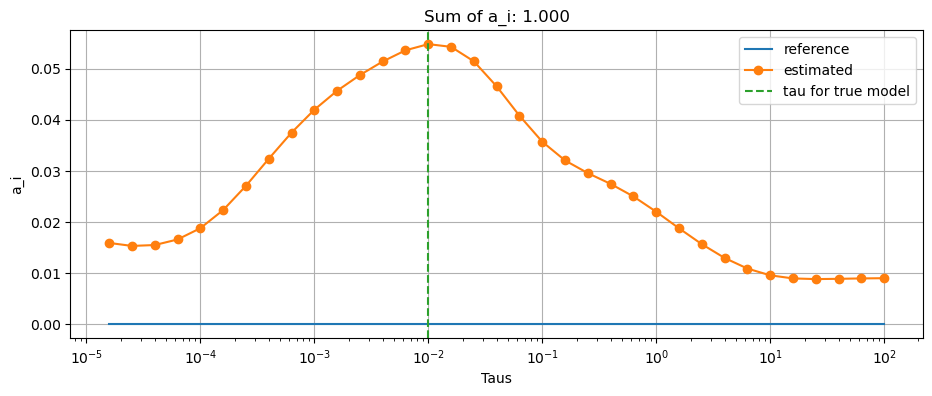

In [ ]:
plt.figure(figsize=(11, 4))
plt.semilogx(taus[1:-1], parm_init_debye[3:-1],color='C0', label="reference")
plt.semilogx(taus[1:-1], mpred_debye[3:-1],color='C1', linestyle='-', marker="o", label="estimated")
plt.axvline(x=1e-2, color='C2', linestyle='--', label="tau for true model")
plt.xlabel("Taus")
plt.ylabel("a_i")
plt.title( f"Sum of a_i: {sum(mpred_debye[2:]):.3f}")
plt.legend()
plt.grid()


In [ ]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq[freq> eps].min())),
            linScalex=0.2)

In [ ]:
freq_plot = freq[freq> eps]

In [ ]:
dest_pelton_real = dest_pelton[:nfreq][freq> eps]
dest_pelton_imag = dest_pelton[nfreq:][freq> eps]
dest_debye_real = dest_debye[:nfreq][freq> eps]
dest_debye_imag = dest_debye[nfreq:][freq> eps]
dobs_real = dobs[:nfreq][freq> eps]
dobs_imag = dobs[nfreq:][freq> eps]

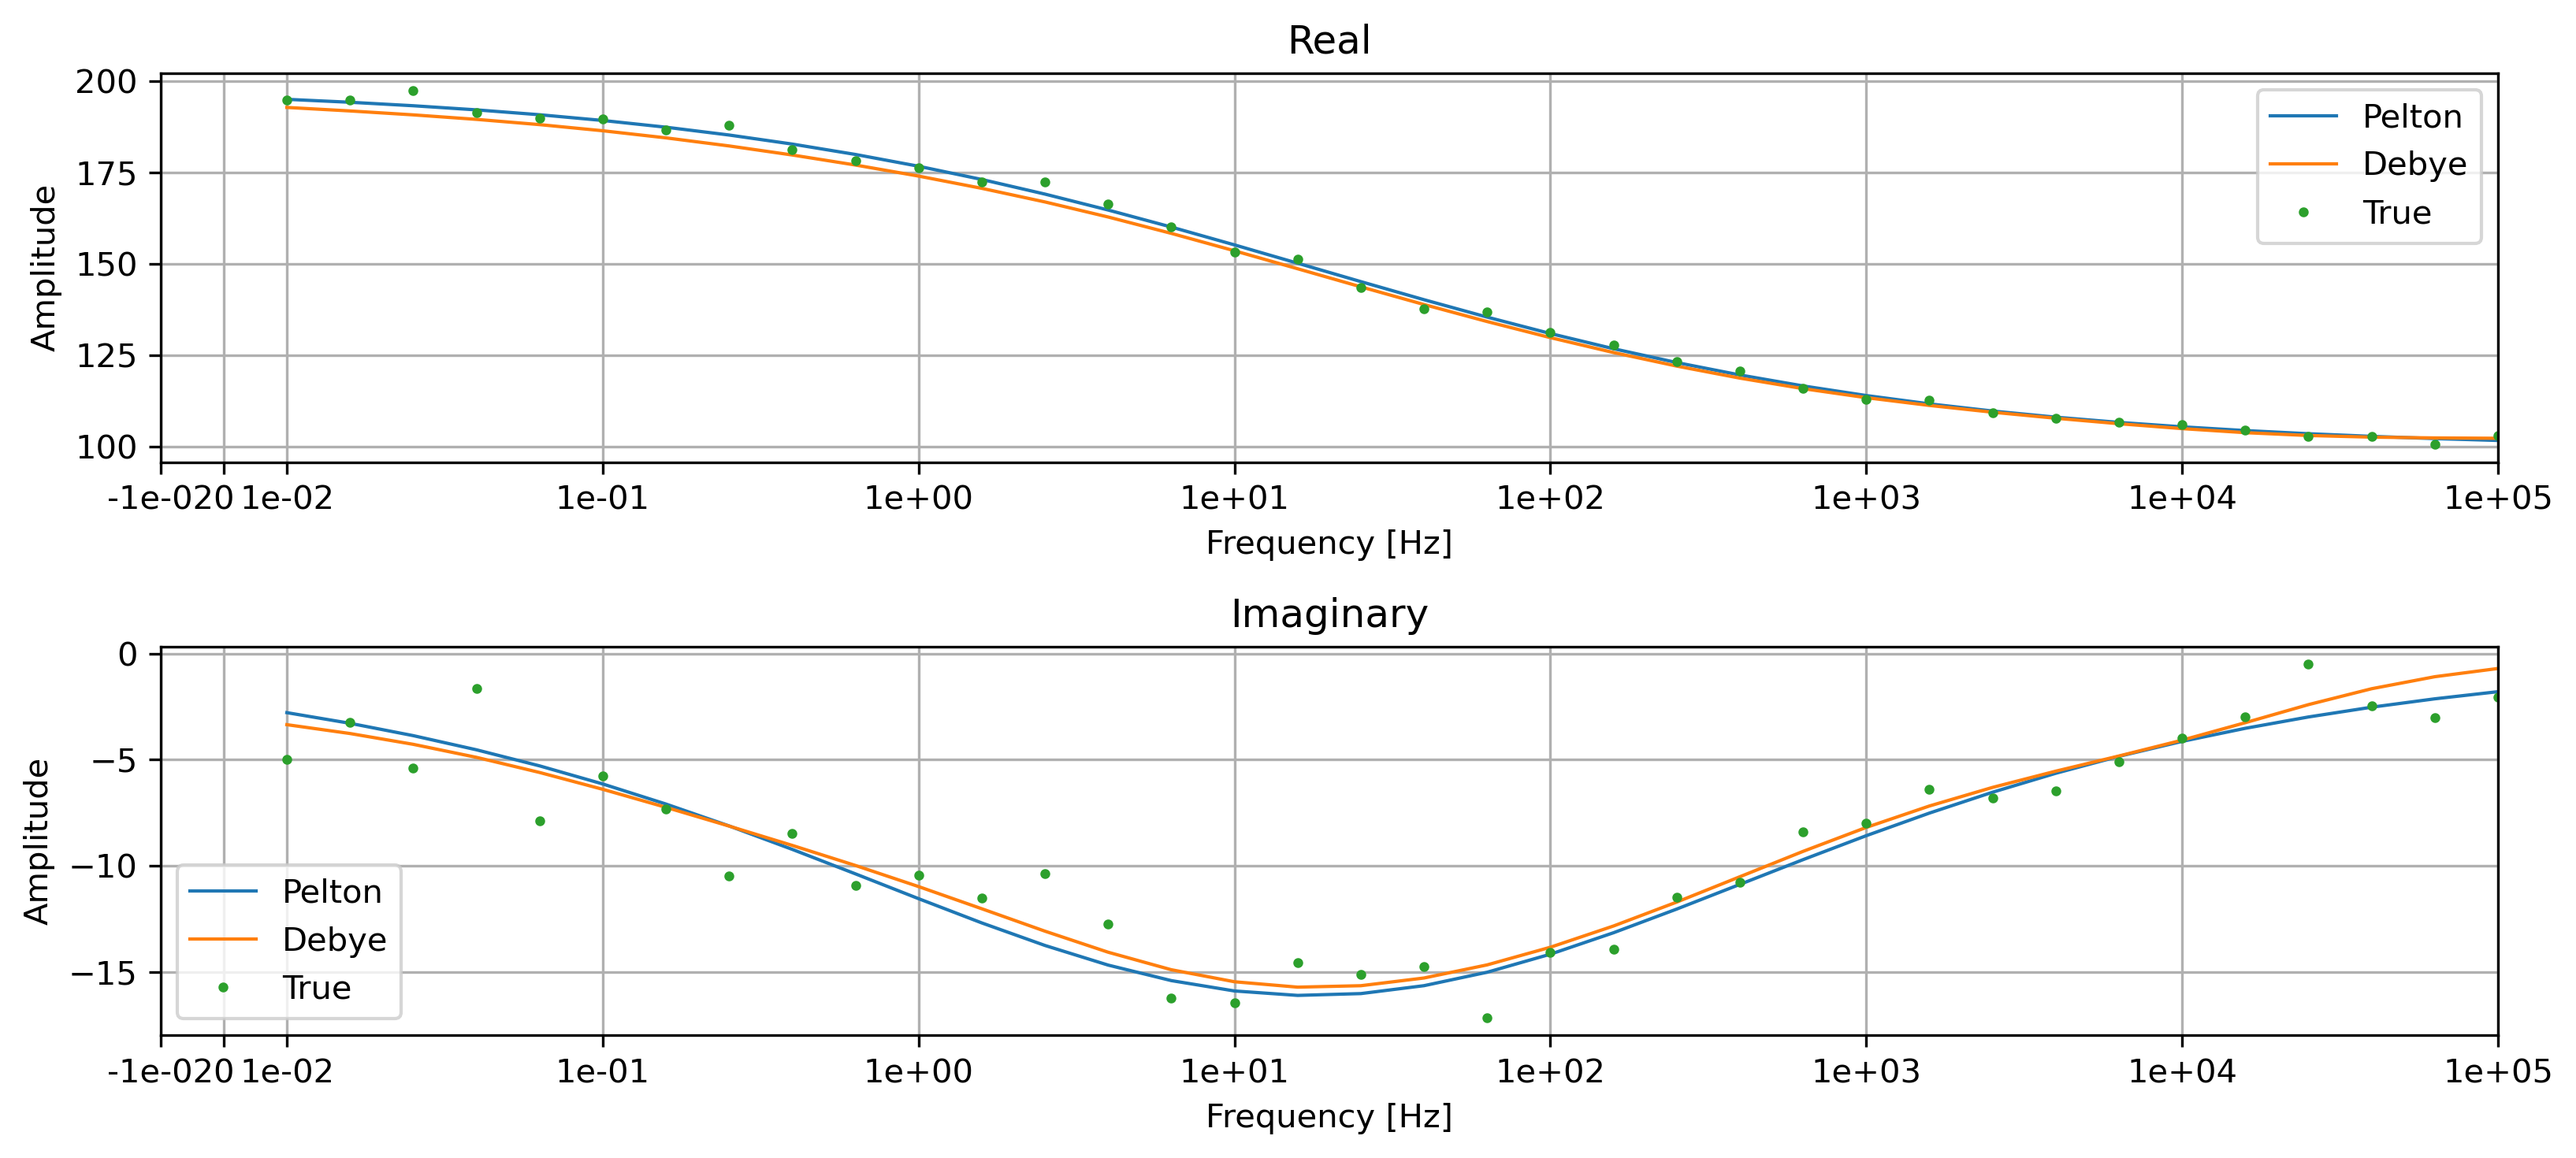

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dest_pelton_real, ax=ax[0], yscale_log=False,
                          color = "C0",label="Pelton")
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dest_debye_real, ax=ax[0], yscale_log=False,
                            color = "C1",label="Debye")
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dobs_real, ax=ax[0], yscale_log=False,
              color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=freq_plot, y=dest_pelton_imag, ax=ax[1], yscale_log=False,
                            color = "C0",label="Pelton")
ax[1] = PL_pelton.semiplx(x=freq_plot, y=dest_debye_imag, ax=ax[1], yscale_log=False,
                            color = "C1",label="Debye")
ax[1] = PL_pelton.semiplx(x=freq_plot, y=dobs_imag, ax=ax[1], yscale_log=False,
                color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()